<a href="https://colab.research.google.com/github/jtfreitas/QInfo_Final/blob/main/FRUIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install tensornetwork jax jaxlib -q gwpy #--quiet flag
!pip uninstall -q matplotlib
!pip install -q matplotlib  #fixing a problem with matplotlib

     |████████████████████████████████| 364 kB 5.1 MB/s 
     |████████████████████████████████| 1.4 MB 37.2 MB/s 
     |████████████████████████████████| 46 kB 2.1 MB/s 
     |████████████████████████████████| 11.2 MB 38.7 MB/s 
     |████████████████████████████████| 51 kB 4.7 MB/s 
     |████████████████████████████████| 895 kB 38.7 MB/s 
     |████████████████████████████████| 55 kB 2.8 MB/s 
     |████████████████████████████████| 3.6 MB 43.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Proceed (y/n)? y
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 

In [1]:
import tensornetwork as tn
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,MaxPooling2D,Conv2D,Dropout,Flatten, AveragePooling2D
from tensornetwork.tn_keras.layers import Conv2DMPO, DenseMPO, DenseDecomp
from tensorflow.keras import regularizers as reg
from tensorflow.keras.callbacks import ModelCheckpoint
import time
import pandas as pd
import matplotlib.pyplot as plt
tn.set_default_backend('tensorflow')
import tensorflow_datasets as tfds
import os


from tensorflow.keras import initializers, regularizers, optimizers, Input
opt = optimizers.Nadam(learning_rate = 0.01)

Dataset from Kaggle loading

In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download moltean/fruits
! unzip -q fruits.zip
! rm fruits.zip
! rm -r fruits-360-original-size/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 1.28G/1.28G [00:09<00:00, 90.6MB/s]
100% 1.28G/1.28G [00:09<00:00, 144MB/s] 


In [5]:
! cp -r /content/fruits-360_dataset/fruits-360/Training /content/
! cp -r /content/fruits-360_dataset/fruits-360/Test /content/
! mv /content/Training FruitDataTrain
! mv /content/Test FruitDataVal


#Classical convolutional NN model
data has 131 labels

image parameters

In [2]:
batch_size = 4*131
img_height = 100
img_width = 100

In [3]:
#Ideally, we want the batch to be large enough to contain at least one sample
#of each class
#Otherwise the model makes conclusions before seeing all types of data

train_ds = tf.keras.utils.image_dataset_from_directory(
  'FruitDataTrain',
  labels = 'inferred',
  label_mode='categorical',
  color_mode = 'rgb',
  validation_split= 0.2,
  subset = 'training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'FruitDataTrain',
  labels = 'inferred',
  label_mode='categorical',
  color_mode = 'rgb',
    validation_split= 0.2,
  subset = 'validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print('\nTest data:')
test_ds = tf.keras.utils.image_dataset_from_directory(
  'FruitDataVal',
  labels = 'inferred',
  label_mode='categorical',
  color_mode = 'rgb',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=22688)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.
Found 67692 files belonging to 131 classes.
Using 13538 files for validation.

Test data:
Found 22688 files belonging to 131 classes.


In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds_train = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_train, labels_batch_train = next(iter(normalized_ds_train))

normalized_ds_val = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_val, labels_batch_val = next(iter(normalized_ds_val))

first_image = image_batch_train[0]
in_shape = first_image.shape

In [5]:
in_shape

TensorShape([100, 100, 3])

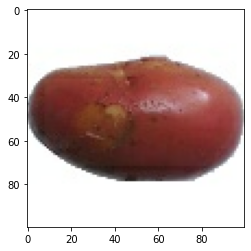

Label : 108


In [6]:
plt.imshow(first_image)
plt.show()
print(f"Label : {np.argmax(labels_batch_train[0])}")

In [7]:
# classical_model = tf.keras.Sequential([
#   tf.keras.Input(shape=in_shape),
#   tf.keras.layers.Conv2D(16,kernel_size = 3, activation='LeakyReLU'),
#   tf.keras.layers.MaxPooling2D(),

#   tf.keras.layers.Conv2D(16,kernel_size = 3, activation='LeakyReLU'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(131, activation='softmax'),
# ])


#Defined a model using some layer regularizers to avoid overfitting
classical_model = tf.keras.Sequential([
  tf.keras.Input(shape=in_shape),
  tf.keras.layers.Conv2D(16, kernel_size = 2, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l2(1e-5), name='conv1'),
  tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool1'),
  tf.keras.layers.Conv2D(32, kernel_size = 2, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l2(1e-5), name='conv2'),
  tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool2'),
  tf.keras.layers.Conv2D(128, kernel_size = 2, activation='relu', kernel_regularizer=regularizers.l2(1e-5), activity_regularizer=regularizers.l2(1e-5), name='conv3'),
  tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool3'),
  tf.keras.layers.Flatten(name='flatten1'),
  tf.keras.layers.Dropout(0.5, name='dropout1'),
  tf.keras.layers.Dense(180, activation = 'relu', name='dense1'),
  tf.keras.layers.Dropout(0.2, name='dropout2'),
  tf.keras.layers.Dense(131, activation='softmax', name='out_dense')
])


classical_model.summary()


lr_schedule = optimizers.schedules.ExponentialDecay(0.01, 800, 0.1)
#The loss was blowing up, meaning the training was reaching a point where
#the learning rate was too large, so I wrote it with a schedule which makes it
#decay to 10% every 500 training steps (batch runs)
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

opt = optimizers.Adam(learning_rate = lr_schedule, amsgrad=True)
classical_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 99, 99, 16)        208       
                                                                 
 max_pool1 (MaxPooling2D)    (None, 49, 49, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 32)        2080      
                                                                 
 max_pool2 (MaxPooling2D)    (None, 24, 24, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 23, 23, 128)       16512     
                                                                 
 max_pool3 (MaxPooling2D)    (None, 11, 11, 128)       0         
                                                                 
 flatten1 (Flatten)          (None, 15488)             0

In [ ]:
check_point = ModelCheckpoint(filepath = 'classic_CNN.hdf5', verbose = 1, save_best_only = True)

with tf.device('GPU'): #just to make sure the training occurs in the GPU, even though it's default
  hist_dict_cl = classical_model.fit(train_ds, validation_data=val_ds, epochs = 15, verbose = 1, shuffle=True, callbacks = [check_point])

In [92]:
#downloading the best model weights locally so we don't have to train the model repeatedly
#I did this to automate things because I ran the model for 50 epochs and had to leave in the meantime.
from google.colab import files

files.download("classic_CNN.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
classical_model.load_weights("classic_CNN.hdf5")

In [ ]:
fig, axs = plt.subplots((1,2), figsize = (18, 6))

for key in hist_dict_cl.history.keys():
  if 'acc' in key:
    axs[0].plot(range(50), hist_dict_cl.history[key], label=key)
  elif 'loss' in key:
    axs[1].plot(range(50), hist_dict_cl.history[key], label=key)

for ax in axs:
  ax.legend()
  ax.grid()

fig.show()

In [ ]:
classical_model.evaluate(test_ds, batch_size=22688)

# A convolutional neural network based on TNs

In [ ]:
tn_convolutional_model = tf.keras.Sequential()
tn_convolutional_model.add(Conv2D(64, kernel_size=18, input_shape = (100, 100, 3)))
tn_convolutional_model.add(Conv2DMPO(64, data_format = "channels_last", kernel_size=5, num_nodes=3, bond_dim=3, activation='LeakyReLU'))
tn_convolutional_model.add(MaxPooling2D())

tn_convolutional_model.add(Conv2DMPO(64, data_format = "channels_last", kernel_size=3, num_nodes=2, bond_dim=3, activation='LeakyReLU'))
tn_convolutional_model.add(MaxPooling2D())

tn_convolutional_model.add(Flatten())
tn_convolutional_model.add(DenseDecomp(10, decomp_size=5, activation='LeakyReLU'))
# tn_convolutional_model.add(Flatten())
tn_convolutional_model.add(Dense(131,activation = 'softmax'))

tn_convolutional_model.summary()

tn_convolutional_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = opt, metrics = ['accuracy'])

# tn_convolutional_model = tf.keras.Sequential([
#     Input(in_shape, batch_size = batch_size),
#     Conv2D(64, kernel_size=18),
#     Conv2DMPO(8, data_format = "channels_last", kernel_size=5, num_nodes=3, bond_dim=3, activation='LeakyReLU'),
#     MaxPooling2D(),
#     Conv2DMPO(64, data_format = "channels_last", kernel_size=3, num_nodes=3, bond_dim=3, activation='LeakyReLU'),
#     MaxPooling2D(),
#     Flatten(),
#     Dense(131, activation = 'softmax')])

# tn_convolutional_model.summary()
# tn_convolutional_model.compile(loss = tf.keras.losses.categorical_crossentropy,
#                 optimizer = opt, metrics = ['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 83, 83, 64)        62272     
                                                                 
 conv2dmpo_12 (Conv2DMPO)    (None, 83, 83, 64)        688       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 41, 41, 64)       0         
 g2D)                                                            
                                                                 
 conv2dmpo_13 (Conv2DMPO)    (None, 41, 41, 64)        1216      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 25600)            

In [ ]:
in_shape

TensorShape([100, 100, 3])

In [ ]:
with tf.device('GPU'):
  hist_dict_convolutional_tn = tn_convolutional_model.fit(train_ds, validation_data=val_ds, 
                                                          batch_size = batch_size, epochs = 10, verbose = 1, shuffle=True,
                                                          workers=0, use_multiprocessing=True)

Epoch 1/10
529/529 [==============================] - 216s 324ms/step - loss: 34942484.0000 - accuracy: 0.0120 - val_loss: 205088.0000 - val_accuracy: 0.0115
Epoch 2/10
529/529 [==============================] - 171s 322ms/step - loss: 176805.8594 - accuracy: 0.0120 - val_loss: 270358.9375 - val_accuracy: 0.0146
Epoch 3/10
529/529 [==============================] - 171s 322ms/step - loss: 98465.4531 - accuracy: 0.0139 - val_loss: 80786.1797 - val_accuracy: 0.0167
Epoch 4/10
529/529 [==============================] - 171s 322ms/step - loss: 66339.9922 - accuracy: 0.0135 - val_loss: 45965.4648 - val_accuracy: 0.0184
Epoch 5/10
529/529 [==============================] - 171s 322ms/step - loss: 46210.0938 - accuracy: 0.0137 - val_loss: 35975.8711 - val_accuracy: 0.0141
Epoch 6/10
529/529 [==============================] - 171s 322ms/step - loss: 40146.2578 - accuracy: 0.0142 - val_loss: 32241.9980 - val_accuracy: 0.0188
Epoch 7/10
529/529 [==============================] - 171s 322ms/step 

In [ ]:
in_shape

TensorShape([100, 100, 3])